In [6]:
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt


In [7]:
def genA(m,n):
    '''Takes in the rows and columns needed to generate A
        Generates a Normalized Random Matrix with IID entries from Standard Normal distribution
    '''
    A = np.random.randn(m, n)

    A_normalized = A / np.linalg.norm(A, axis=0)

    return A_normalized

In [8]:
def genSparse(N,s):
    ''' Takes in cardinality s which are generated at random from integers 1 to N
         Generates a sparse vector x and it also return the indexes where it is non-zero
    '''
    x=np.zeros(N)
    index=np.random.choice(N,s,replace=False)

    non_zero_entries=np.random.uniform(-10,10,s)
    non_zero_entries=np.where(non_zero_entries==0,non_zero_entries+2.5,non_zero_entries)

    x[index]=non_zero_entries

    return x, index.tolist()

In [9]:
def genNoise(N,sigma):
    ''' Takes in the length of noise vector and standard deviation to be used to make a noise vector,
        Generates a Noise Vector
    '''
    noise=np.random.normal(0,sigma,N)
    return noise

In [10]:
def least_square(A, y):
    return np.linalg.lstsq(A, y, rcond=None)[0]

def omp(A, y, tol=0.0001, max_iter=None):
    M, N = A.shape
    r = np.copy(y)
    x_k = np.zeros(N)
    indexSet = []
    err = np.linalg.norm(r)

    A_T = A.T

    At_r = A_T @ r

    iter_count = 0
    while err > tol:
        if max_iter is not None and iter_count >= max_iter:
            break

        lambdaK = np.argmax(np.abs(At_r))
        if lambdaK in indexSet:
            break

        indexSet.append(lambdaK)

        DeltaK = A[:, indexSet]
        a_k = least_square(DeltaK, y)
        x_k[indexSet] = a_k

        r = y - A @ x_k
        err = np.linalg.norm(r)

        At_r = A_T @ r

        iter_count += 1

    return x_k, indexSet


In [11]:
def NoiselessCaseParallel(N, s_size, mc_time):
    M = range(1, N)
    S = range(1, s_size)

    plot_recover = np.zeros((len(M), len(S)))
    plot_normalError = np.zeros((len(M), len(S)))

    # Define a helper function for parallel execution
    def monte_carlo_simulation(m, s):

        A = genA(m, N)
        rec_count = 0
        normal_error = 0

        for i in range(mc_time):
            print(f"Processing m={m}, s={s}, iteration={i+1}/{mc_time}")

            x, sparseIndex = genSparse(N, s)
            y = np.dot(A, x)
            x_k, recIndex = omp(A, y)

            normal_error += np.linalg.norm(x - x_k) / np.linalg.norm(x)
            if len(sparseIndex) == len(recIndex) and sorted(recIndex) == sorted(sparseIndex):
                rec_count += 1

        return rec_count / mc_time, normal_error / mc_time

    # Use ThreadPoolExecutor for parallelization
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {}
        for m in M:
            for s in S:
                future = executor.submit(monte_carlo_simulation, m, s)
                futures[future] = (m, s)

        for future in concurrent.futures.as_completed(futures):
            m, s = futures[future]
            plot_recover[m - 1, s - 1], plot_normalError[m - 1, s - 1] = future.result()

    return plot_recover, plot_normalError

Streaming output truncated to the last 5000 lines.

Processing m=19, s=14, iteration=1954/2000
Processing m=19, s=17, iteration=973/2000
Processing m=19, s=16, iteration=1451/2000
Processing m=19, s=16, iteration=1452/2000
Processing m=19, s=14, iteration=1955/2000
Processing m=19, s=17, iteration=974/2000Processing m=19, s=19, iteration=309/2000
Processing m=19, s=14, iteration=1956/2000
Processing m=19, s=15, iteration=1639/2000
Processing m=19, s=19, iteration=310/2000
Processing m=19, s=14, iteration=1957/2000Processing m=19, s=18, iteration=681/2000
Processing m=19, s=17, iteration=975/2000Processing m=19, s=15, iteration=1640/2000
Processing m=19, s=19, iteration=311/2000
Processing m=19, s=16, iteration=1453/2000

Processing m=19, s=16, iteration=1454/2000
Processing m=19, s=15, iteration=1641/2000

Processing m=19, s=14, iteration=1958/2000Processing m=19, s=19, iteration=312/2000

Processing m=19, s=16, iteration=1455/2000
Processing m=19, s=17, iteration=976/2000
Processing m

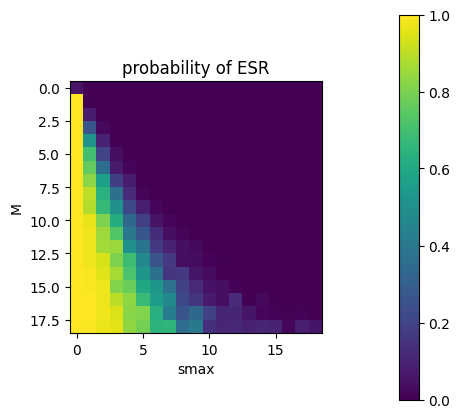

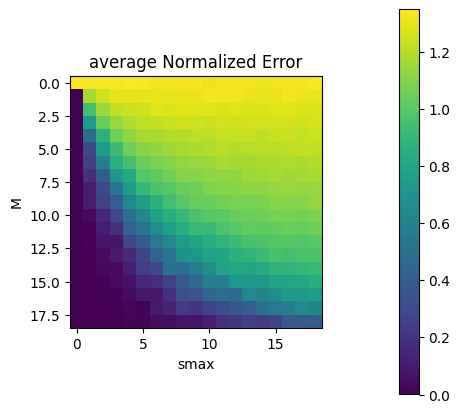

In [12]:
p, E = NoiselessCaseParallel(20,20,2000)
Figure1 = plt.figure(figsize = (5,5))
F1 = Figure1.add_subplot(1,1,1)
ESR = F1.imshow(p)
plt.colorbar(ESR,pad = 0.2)
F1.set_xlabel("smax")
F1.set_ylabel("M")
F1.title.set_text("probability of ESR")
plt.savefig('noiseless_20_ESR.png')

Figure2 = plt.figure(figsize = (5,5))
F2 = Figure2.add_subplot(1,1,1)
E = F2.imshow(E)
plt.colorbar(E,pad = 0.2)
F2.set_xlabel("smax")
F2.set_ylabel("M")
F2.title.set_text("average Normalized Error")

plt.savefig('noiseless_20_Err.png')

In [13]:
# p, E = NoiselessCaseParallel(50,50,2000)
# Figure1 = plt.figure(figsize = (5,5))
# F1 = Figure1.add_subplot(1,1,1)
# ESR = F1.imshow(p)
# plt.colorbar(ESR,pad = 0.2)
# F1.set_xlabel("smax")
# F1.set_ylabel("M")
# F1.title.set_text("probability of ESR")
# plt.savefig('noiseless_50_ESR.png')

# Figure2 = plt.figure(figsize = (5,5))
# F2 = Figure2.add_subplot(1,1,1)
# E = F2.imshow(E)
# plt.colorbar(E,pad = 0.2)
# F2.set_xlabel("smax")
# F2.set_ylabel("M")
# F2.title.set_text("average Normalized Error")

# plt.savefig('noiseless_50_Err.png')

In [14]:
# p, E = NoiselessCaseParallel(100,20,2000)
# Figure1 = plt.figure(figsize = (5,5))
# F1 = Figure1.add_subplot(1,1,1)
# ESR = F1.imshow(p)
# plt.colorbar(ESR,pad = 0.2)
# F1.set_xlabel("smax")
# F1.set_ylabel("M")
# F1.title.set_text("probability of ESR")
# plt.savefig('noiseless_100_ESR.png')

# Figure2 = plt.figure(figsize = (5,5))
# F2 = Figure2.add_subplot(1,1,1)
# E = F2.imshow(E)
# plt.colorbar(E,pad = 0.2)
# F2.set_xlabel("smax")
# F2.set_ylabel("M")
# F2.title.set_text("average Normalized Error")

# plt.savefig('noiseless_100_Err.png')